# Averaging Triads 

In [1]:
import os
import h5py
import numpy as np
from scipy.signal.windows import get_window

import matplotlib.pyplot as plt

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import dspec
from library import cptools as cp

## Load Data

In [2]:
# data path
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_AVG.h5"
xps_path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_XPS.h5"

# load covariance data
with h5py.File(path, "r") as f:
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    cov_xx = f["cov XX"][()]
    cov_yy = f["cov YY"][()]
    eicp_xx = f["eicp XX 1"][()]
    eicp_yy = f["eicp YY 1"][()]
    
# load cross-power spectral data
with h5py.File(xps_path, "r") as f:
    xps_xx = f["XPS XX"][()]
    xps_yy = f["XPS YY"][()]
    
Nlst = len(lst)
Ntrx = eicp_xx.shape[1]
Ntry = eicp_yy.shape[1]
Ndx = eicp_xx.shape[-1]
Ndy = eicp_yy.shape[-1]

## Sums and Differences
The differences allow to investigate how different averaging methods affect the noise levels.

In [3]:
sum_xx = (eicp_xx[0] + eicp_xx[1]) / 2
dif_xx = (eicp_xx[0] - eicp_xx[1]) / 2
sum_yy = (eicp_yy[0] + eicp_yy[1]) / 2
dif_yy = (eicp_yy[0] - eicp_yy[1]) / 2

## Invert Covariance Matrices and Compute Weights
The minimum variance weights for dependent variables are $w_j=\sum_{i} C^{-1}_{ij}$, where $C_{ij}$ is the covariance between variables $x_i$ and $x_j$. 

In [39]:
cov_xx_inv = np.linalg.inv(cov_xx.real)
cov_yy_inv = np.linalg.inv(cov_yy.real)

# covariance weights
w_cov_xx = np.sum(cov_xx_inv, axis=1).swapaxes(0, 1)
w_cov_yy = np.sum(cov_yy_inv, axis=1).swapaxes(0, 1)

# variance weights
w_var_xx = np.array([1 / (cov_xx[:, i, i]) for i in range(Ntrx)])
w_var_yy = np.array([1 / (cov_yy[:, i, i]) for i in range(Ntry)])

## Delay Transform

In [5]:
# sampling frequency
fs = 10.24 * 1e-6

# delay array
delay = dspec.delay(n=Ndx)

# window function
w = get_window("blackmanharris", Ndx)

# delay transform sums and differences
sum_xx_ft = dspec.fft(sum_xx, W=w, shift=True) / fs
sum_yy_ft = dspec.fft(sum_yy, W=w, shift=True) / fs
dif_xx_ft = dspec.fft(dif_xx, W=w, shift=True) / fs
dif_yy_ft = dspec.fft(dif_yy, W=w, shift=True) / fs

## Average

In [50]:
sum_xx_ft_mean = np.mean(sum_xx_ft, axis=0)
sum_xx_ft_median = np.array([cp.geomed(sum_xx_ft[:, i], weights=w_var_xx[:, i], axis=0) for i in range(Nlst)])
sum_xx_ft_cov = ((np.moveaxis(sum_xx_ft, -1, 0) * w_cov_xx).sum(axis=1) / w_cov_xx.sum(axis=0)).swapaxes(0, 1)
sum_xx_ft_var = ((np.moveaxis(sum_xx_ft, -1, 0) * w_var_xx).sum(axis=1) / w_var_xx.sum(axis=0)).swapaxes(0, 1)

sum_yy_ft_mean = np.mean(sum_yy_ft, axis=0)
sum_yy_ft_median = np.array([cp.geomed(sum_yy_ft[:, i], weights=w_var_yy[:, i], axis=0) for i in range(Nlst)])
sum_yy_ft_cov = ((np.moveaxis(sum_yy_ft, -1, 0) * w_cov_yy).sum(axis=1) / w_cov_yy.sum(axis=0)).swapaxes(0, 1)
sum_yy_ft_var = ((np.moveaxis(sum_yy_ft, -1, 0) * w_var_yy).sum(axis=1) / w_var_yy.sum(axis=0)).swapaxes(0, 1)

dif_xx_ft_mean = np.mean(dif_xx_ft, axis=0)
dif_xx_ft_median = np.array([cp.geomed(dif_xx_ft[:, i], weights=w_var_xx[:, i], axis=0) for i in range(Nlst)])
dif_xx_ft_cov = ((np.moveaxis(dif_xx_ft, -1, 0) * w_cov_xx).sum(axis=1) / w_cov_xx.sum(axis=0)).swapaxes(0, 1)
dif_xx_ft_var = ((np.moveaxis(dif_xx_ft, -1, 0) * w_var_xx).sum(axis=1) / w_var_xx.sum(axis=0)).swapaxes(0, 1)

dif_yy_ft_mean = np.mean(dif_yy_ft, axis=0)
dif_yy_ft_median = np.array([cp.geomed(dif_yy_ft[:, i], weights=w_var_yy[:, i], axis=0) for i in range(Nlst)])
dif_yy_ft_cov = ((np.moveaxis(dif_yy_ft, -1, 0) * w_cov_yy).sum(axis=1) / w_cov_yy.sum(axis=0)).swapaxes(0, 1)
dif_yy_ft_var = ((np.moveaxis(dif_yy_ft, -1, 0) * w_var_yy).sum(axis=1) / w_var_yy.sum(axis=0)).swapaxes(0, 1)

## Plot Delay Power Spectra
As can be seen in this plot, the covariance weights give yield the smallest noise levels, but instead they introduce a positive bias in the power spectrum.

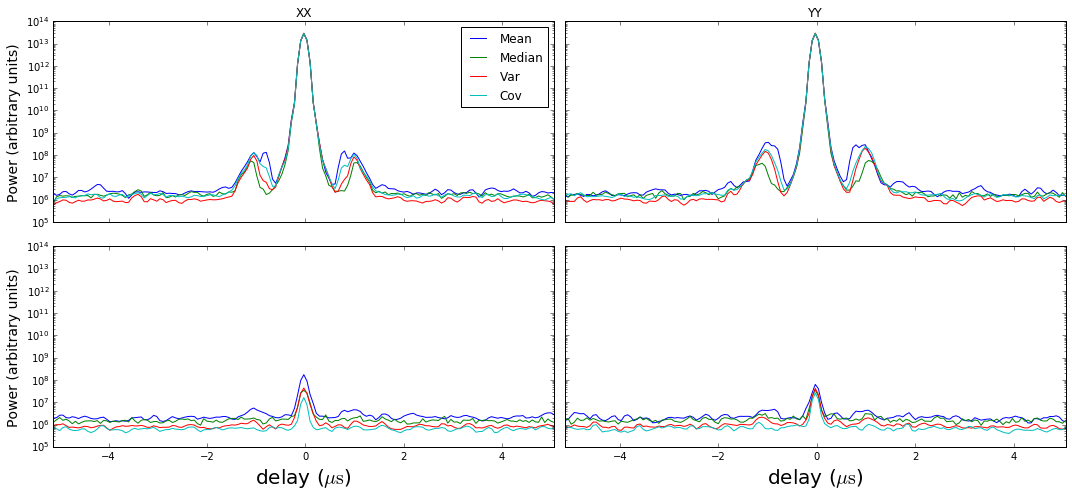

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True, sharey=True)
ax[0, 0].plot(delay, np.mean(np.abs(sum_xx_ft_mean)**2, axis=0), label="Mean")
ax[0, 0].plot(delay, np.mean(np.abs(sum_xx_ft_median)**2, axis=0), label="Median")
ax[0, 0].plot(delay, np.mean(np.abs(sum_xx_ft_var)**2, axis=0), label="Var")
ax[0, 0].plot(delay, np.mean(np.abs(sum_xx_ft_cov)**2, axis=0), label="Cov")
ax[0, 1].plot(delay, np.mean(np.abs(sum_yy_ft_mean)**2, axis=0), label="Mean")
ax[0, 1].plot(delay, np.mean(np.abs(sum_yy_ft_median)**2, axis=0), label="Median")
ax[0, 1].plot(delay, np.mean(np.abs(sum_yy_ft_var)**2, axis=0), label="Var")
ax[0, 1].plot(delay, np.mean(np.abs(sum_yy_ft_cov)**2, axis=0), label="Cov")
ax[1, 0].plot(delay, np.mean(np.abs(dif_xx_ft_mean)**2, axis=0), label="Mean")
ax[1, 0].plot(delay, np.mean(np.abs(dif_xx_ft_median)**2, axis=0), label="Median")
ax[1, 0].plot(delay, np.mean(np.abs(dif_xx_ft_var)**2, axis=0), label="Var")
ax[1, 0].plot(delay, np.mean(np.abs(dif_xx_ft_cov)**2, axis=0), label="Cov")
ax[1, 1].plot(delay, np.mean(np.abs(dif_yy_ft_mean)**2, axis=0), label="Mean")
ax[1, 1].plot(delay, np.mean(np.abs(dif_yy_ft_median)**2, axis=0), label="Median")
ax[1, 1].plot(delay, np.mean(np.abs(dif_yy_ft_var)**2, axis=0), label="Var")
ax[1, 1].plot(delay, np.mean(np.abs(dif_yy_ft_cov)**2, axis=0), label="Cov")
ax[0, 0].legend()
ax[1, 0].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[1, 1].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[0, 0].set_ylabel(r"Power (arbitrary units)", fontsize=14)
ax[1, 0].set_ylabel(r"Power (arbitrary units)", fontsize=14)
ax[0, 0].set_title("XX")
ax[0, 1].set_title("YY")
plt.setp(ax, xlim=[min(delay), max(delay)], yscale="log")
plt.tight_layout()

# Averaging Cross-Power Spectra
Similar analysis as above, but for cross-power spectra. This will allow us to identify noise biases and try systematics mitigation by removing cross-terms between identical triads.

In [67]:
w_xps_cov_xx = np.array([[w_cov_xx[i] * w_cov_xx[j] for i in range(Ntrx)] for j in range(Ntrx)])
w_xps_cov_yy = np.array([[w_cov_yy[i] * w_cov_yy[j] for i in range(Ntry)] for j in range(Ntry)])
w_xps_var_xx = np.array([[1 / (cov_xx[:, i, i] * cov_xx[:, j, j]) for i in range(Ntrx)] for j in range(Ntrx)])
w_xps_var_yy = np.array([[1 / (cov_yy[:, i, i] * cov_yy[:, j, j]) for i in range(Ntry)] for j in range(Ntry)])

In [79]:
xx_ft_1 = dspec.fft(eicp_xx[0], shift=True, W=w) / fs
xx_ft_2 = dspec.fft(eicp_xx[1], shift=True, W=w) / fs
xx_ft_1_median = np.array([cp.geomed(xx_ft_1[:, i], weights=w_var_xx[:, i], axis=0) for i in range(Nlst)])
xx_ft_2_median = np.array([cp.geomed(xx_ft_2[:, i], weights=w_var_xx[:, i], axis=0) for i in range(Nlst)])
xps_xx_median = (xx_ft_1_median * xx_ft_2_median.conjugate()).mean(axis=0)

yy_ft_1 = dspec.fft(eicp_yy[0], shift=True, W=w) / fs
yy_ft_2 = dspec.fft(eicp_yy[1], shift=True, W=w) / fs
yy_ft_1_median = np.array([cp.geomed(yy_ft_1[:, i], weights=w_var_yy[:, i], axis=0) for i in range(Nlst)])
yy_ft_2_median = np.array([cp.geomed(yy_ft_2[:, i], weights=w_var_yy[:, i], axis=0) for i in range(Nlst)])
xps_yy_median = (yy_ft_1_median * yy_ft_2_median.conjugate()).mean(axis=0)

In [68]:
xps_xx_mean = np.mean(xps_xx, axis=(0, 1, 2))
xps_xx_cov = (np.moveaxis(xps_xx, -1, 0) * w_xps_cov_xx).sum(axis=(1, 2, 3)) / w_xps_cov_xx.sum(axis=(0, 1, 2))
xps_xx_var = (np.moveaxis(xps_xx, -1, 0) * w_xps_var_xx).sum(axis=(1, 2, 3)) / w_xps_var_xx.sum(axis=(0, 1, 2))

xps_yy_mean = np.mean(xps_yy, axis=(0, 1, 2))
xps_yy_cov = (np.moveaxis(xps_yy, -1, 0) * w_xps_cov_yy).sum(axis=(1, 2, 3)) / w_xps_cov_yy.sum(axis=(0, 1, 2))
xps_yy_var = (np.moveaxis(xps_yy, -1, 0) * w_xps_var_yy).sum(axis=(1, 2, 3)) / w_xps_var_yy.sum(axis=(0, 1, 2))

## Plot Cross-Power Spectra
As can be seen in the plot, the inverse variance weighting produces the lowest noise level in the power spectrum. The covariance weighting produces a bias towards real positive values. The median averaging is best at suppressing the systematic ripple.

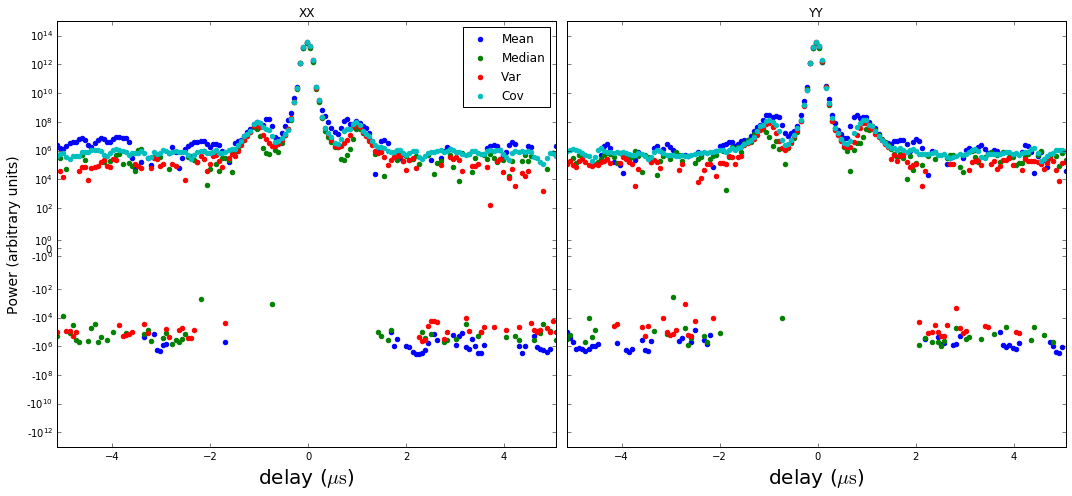

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
ax[0].scatter(delay, xps_xx_mean, label="Mean", color="b")
ax[0].scatter(delay, xps_xx_median, label="Median", color="g")
ax[0].scatter(delay, xps_xx_var, label="Var", color="r")
ax[0].scatter(delay, xps_xx_cov, label="Cov", color="c")
ax[1].scatter(delay, xps_yy_mean, label="Mean", color="b")
ax[1].scatter(delay, xps_yy_median, label="Median", color="g")
ax[1].scatter(delay, xps_yy_var, label="Var", color="r")
ax[1].scatter(delay, xps_yy_cov, label="Cov", color="c")
ax[0].legend(scatterpoints=1)
ax[0].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[1].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[0].set_ylabel(r"Power (arbitrary units)", fontsize=14)
ax[0].set_title("XX")
ax[1].set_title("YY")
plt.setp(ax, xlim=[min(delay), max(delay)], yscale="symlog")
plt.tight_layout()

## Remove Inter-Triad Cross-Terms
As can be seen in the plot this lead to a slight reduces excess power slightly around the systematic bump. 

In [84]:
w_inter_xps_var_xx = w_xps_var_xx.copy()
w_inter_xps_var_yy = w_xps_var_yy.copy()

for i in range(Ntrx):
    w_inter_xps_var_xx[i, i] = 0 
for i in range(Ntry):
    w_inter_xps_var_yy[i, i] = 0 

In [85]:
inter_xps_xx_var = (np.moveaxis(xps_xx, -1, 0) * w_inter_xps_var_xx).sum(axis=(1, 2, 3)) / w_inter_xps_var_xx.sum(axis=(0, 1, 2))
inter_xps_yy_var = (np.moveaxis(xps_yy, -1, 0) * w_inter_xps_var_yy).sum(axis=(1, 2, 3)) / w_inter_xps_var_yy.sum(axis=(0, 1, 2))

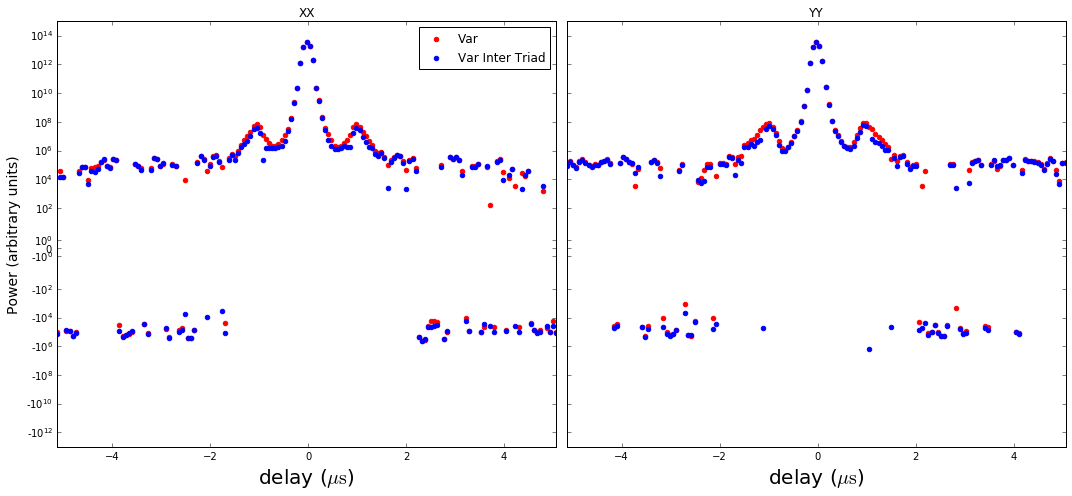

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
ax[0].scatter(delay, xps_xx_var, label="Var", color="r")
ax[1].scatter(delay, xps_yy_var, label="Var", color="r")
ax[0].scatter(delay, inter_xps_xx_var, label="Var Inter Triad", color="b")
ax[1].scatter(delay, inter_xps_yy_var, label="Var Inter Triad", color="b")
ax[0].legend(scatterpoints=1)
ax[0].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[1].set_xlabel(r"delay ($\mu\mathrm{s}$)")
ax[0].set_ylabel(r"Power (arbitrary units)", fontsize=14)
ax[0].set_title("XX")
ax[1].set_title("YY")
plt.setp(ax, xlim=[min(delay), max(delay)], yscale="symlog")
plt.tight_layout()